<h4> Imports

In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\RK4_SinDy-main"
sys.path.insert(0, filePath)

import numpy as np
import torch as T
import os
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import pysindy as ps
import Dictionary.polynomial_library_torch as pl_torch
from Functions.utils import printing_learned_model
from Functions.modules import coeffs_dictionary
from Functions.models import sdof_free_vibr, sdof_harmonic
from Functions.learning_models import learning_sparse_model
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

<h4> Random Seed

In [2]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

<h4> Parameters

In [3]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    save_model_path: str = "./Results/SDOF_free_vibration/"
    # save_model_path: str = "./Results/SDOF_harmonic_excitation/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 50.0
    timestep: float = 1.
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 2
    tikz_save: bool = False
    noise_level: float = 1e-2

Params = parameters()

In [4]:
os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

In [5]:
dynModel = sdof_free_vibr
# dynModel = sdof_harmonic

In [24]:
with closing(
    Tee(
        Params.save_model_path + "Noisy_SDOF_free_vibration.log",
        # Params.save_model_path + "Noisy_SDOF_Harmonic_Excitation.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    
    print(f"\n{'*'*100}")
    print(f"{'*'*10} TIME STEP {parameters.timestep:.3f} {'*'*10}")
    print(f"{10*'*'} POLYNOMIAL ORDER {parameters.poly_order:.0f} {10*'*'}")
    print(f"{10*'*'} NOISE LEVEL {parameters.noise_level:.3f} {10*'*'}")


****************************************************************************************************
********** TIME STEP 1.000 **********
********** POLYNOMIAL ORDER 2 **********
********** NOISE LEVEL 0.010 **********


In [6]:
ts = np.arange(0, Params.timefinal, Params.timestep)
# Initial condition and simulation time
x0 = [0.1, 0.1]
# Solve the equation
sol = solve_ivp(lambda t, x: dynModel(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
# x = sol
x = np.transpose(sol.y).reshape(1, -1, Params.dim_x)

x = np.random.normal(loc=x, scale=parameters.noise_level * np.abs(x), size=x.shape)

x_original = x.copy()


In [ ]:
# Define dataloaders
train_dset = list(zip(T.tensor(x).float(), ts.reshape(1, -1, 1)))
train_dl = T.utils.data.DataLoader(train_dset, batch_size=Params.bs)
dataloaders = {"train": train_dl}

# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x[0])
funs_dictionary_size = funs_dictionary.transform(x[0]).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size, Params.dim_x)

# Learning Coefficients
Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, dataloaders, Params, quite=True)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

In [15]:
a = T.ones(size=(49,)).unsqueeze(1)
# a = a.unsqueeze(1)
a.shape

torch.Size([49, 1])

In [18]:
i = 1
for y in dataloaders['train']:
    print(f'iteration {i}\n')
    i += 1
    print(y[1][0].shape)

iteration 1

torch.Size([50, 1])


In [28]:
# Fit a model using Sindy
poly_order = Params.poly_order
threshold = Params.tol_coeffs

# model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold), feature_library=ps.PolynomialLibrary(degree=poly_order),)
# model.fit(x.reshape(-1, parameters.dim_x), t=Params.timestep)

# Simulate all identified model
f1 = lambda z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).reshape(-1,)
learnt_deri = lambda z, t: np.array(f1(z))
# learnt_deri = lambda z, t: np.array(f1(z)) + np.array([0, np.cos(2 * t)])

ts_refine = np.arange(0, Params.timefinal, 1e-2)

sol = solve_ivp(lambda t, x: dynModel(x, t), [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine)
x_refine = np.transpose(sol.y).reshape(1, -1, Params.dim_x)

# x_sindy = model.simulate(x0, ts_refine).reshape(1, -1, Params.dim_x)

sol_learnt = solve_ivp(lambda t, x: learnt_deri(x, t), [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine,)
x_learnt = np.transpose(sol_learnt.y).reshape(1, -1, Params.dim_x)

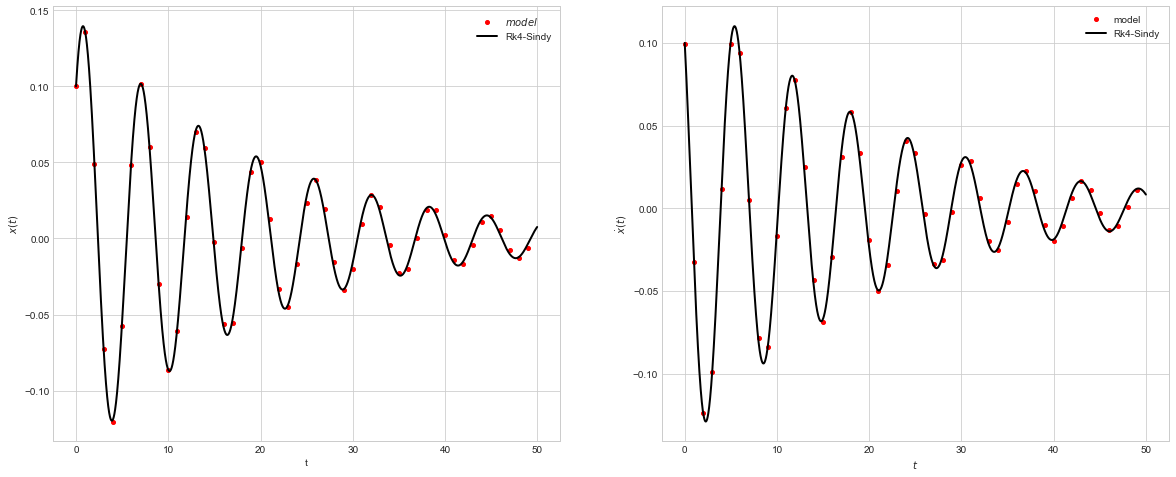

In [29]:
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(ts, x[0, :, 0], "ro", markersize=4, label="$model$", **plot_kws)
axs[0].plot(ts_refine, x_learnt[0, :, 0], "k-", label="Rk4-Sindy", **plot_kws)
# axs[0].plot(ts_refine, x_sindy[0, :, 0], "g:", label="Sindy", **plot_kws)

axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x(t)$")

axs[1].plot(ts, x[0, :, 1], "ro", markersize=4, label="model", **plot_kws)
axs[1].plot(ts_refine, x_learnt[0, :, 1], "k-", markersize=4, label="Rk4-Sindy",**plot_kws)
# axs[1].plot(ts_refine, x_sindy[0, :, 1], "g:", label="Sindy", **plot_kws)

axs[1].legend()

axs[1].set(xlabel="$t$", ylabel="$\dot{x}(t)$")

# if Params.tikz_save:
#     tikzplotlib.save(
#         Params.save_model_path + "Linear2D_timestep_{}.tex".format(Params.timestep)
#     )
plt.show()
# fig.savefig(
#     Params.save_model_path + "Linear2D_timestep_{}.pdf".format(Params.timestep),
#     bbox_inches="tight",
#     pad_inches=0,
# )

In [31]:
with closing(
    Tee(
        Params.save_model_path + "Noisy_SDOF_free_vibration.log",
        # Params.save_model_path + "Noisy_SDOF_Harmonic_Excitation.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print(f"{'='*50}\nRK4 Inspired Methods Sparse Identification")
    printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())
    # print(f"{'='*50}\nSindy Approach")
    # model.print()
    print(f"{'='*50}\n{'*'*100}")


RK4 Inspired Methods Sparse Identification
dx0'= 1.010 x1 + -0.073 x0 x1 
dx1'= -1.001 x0 + -0.101 x1 
****************************************************************************************************
